# Latent Population Analysis with Calcium likelihoods

The following notebook will simulate neural population activity with LDS structure, and run LDS inference on it with the the Calcium likelihood and Gaussian likelihood.

Make sure you have the following packages in your environment:<br />
autograd <br />
jax<br />
cython<br />
ipywidgets<br />
pandas<br />
ssm


There is an environment file in the github repo that should be work to install all relevant packages.

In [1]:
## import packages

import autograd.numpy as anp
import autograd.numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


import jax
import jax.numpy as jnp
# Current convention is to import original numpy as "onp"
import numpy as onp
from jax import grad, jit, vmap
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of 
from jax import random
from jax import jacfwd
from functools import partial

import GP_fourier as gpf 
from CA.CA_new import CA_Emissions
from CA.misc import bbvi, make_cov, softplus

from scipy.io import loadmat


In [2]:
npr.seed(123)
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)

from ssm import LDS
from ssm.util import random_rotation


### Simulate (AR1) LDS data

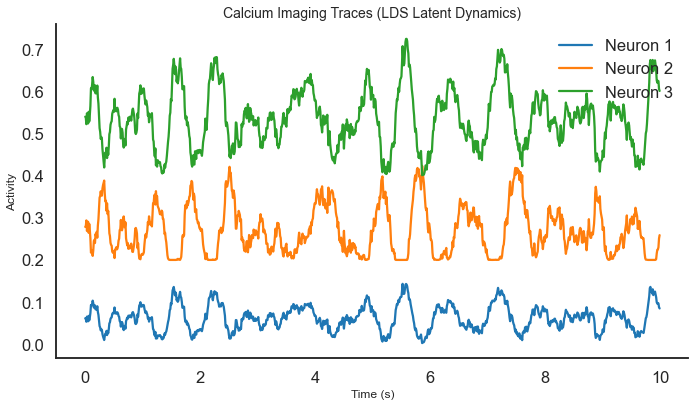

In [12]:
T = 1000   # number of time bins
D = 2      # number of latent dimensions
N = 40     # number of observed dimensions
bin_size = 0.01
link_func = "softplus"
# Make an LDS with somewhat interesting dynamics parameters
true_lds = LDS(N, D, emissions="calcium", emission_kwargs={"bin_size":bin_size,"link":link_func})
A0 = .99 * random_rotation(D, theta=anp.pi/40)
# S = (1 + 3 * npr.rand(D))
S = anp.arange(1, D+1)
R = anp.linalg.svd(npr.randn(D, D))[0] * S
A = R.dot(A0).dot(anp.linalg.inv(R))
b =  anp.zeros(D)
true_lds.dynamics.As[0] = A
true_lds.dynamics.bs[0] = b
true_lds.dynamics.Sigmas = true_lds.dynamics.Sigmas / anp.max(true_lds.dynamics.Sigmas[0]) * 0.5
# true_lds.dynamics.Sigmas = true_lds.dynamics.Sigmas 
# true_lds.emissions.ds[0] = np.clip(npr.randn(N), -10, 0.1)
true_lds.emissions.ds[0] = 10.0 + 3.0 * npr.randn(N)
true_lds.emissions.As[0] = anp.clip(0.85 + 0.05 * npr.randn(N), 0.8, 0.95)
true_lds.emissions.betas[0] = 1.0 * anp.ones(N)



# set noise on correct scale
true_lds.emissions.inv_etas[0] = anp.log(1e-2 * anp.ones(N))

x, y = true_lds.sample(T)
smooth_y = true_lds.smooth(x, y)

u = onp.zeros((T,0))
mask = onp.ones_like(y)
tag = None
lls = true_lds.emissions.log_likelihoods(y, u, mask, tag, x)

lambdas = true_lds.emissions.mean(true_lds.emissions.forward(x, u, tag))[:,0,:]


time_axis = anp.arange(T) * bin_size  # Convert bins to seconds
neurons_to_plot = 3
offset = .2 #offset calcium trace examples
plt.figure(figsize=(10, 6))

# Plot each neuron with a vertical offset for clarity
for i in range(neurons_to_plot):
    plt.plot(time_axis, lambdas[:, i] + (i * offset), label=f'Neuron {i+1}')

# --- Aesthetic Refinements ---
plt.title('Calcium Imaging Traces (LDS Latent Dynamics)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Activity', fontsize=12)

# Remove the top and right spines for a cleaner "Nature-style" look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

### LDS inference

In [13]:

test_As = anp.zeros_like(true_lds.emissions.As[0])
test_As = true_lds.emissions.As[0] + 0.0
test_etas = anp.zeros_like(true_lds.emissions.inv_etas[0])
for d in range(N):
    yd = y[:,d]
    # test_As[d] = 1.0 / np.sum(yd[:-1] **2 ) * np.dot(yd[:-1], yd[1:]) * 1.0 # deflate because not taking into account spikes
    sqerr = anp.sum( ( yd[1:] - test_As[d] * yd[:-1] )**2 ) / (T-1)
    test_etas[d] = sqerr 
    
    lds = LDS(N, D, emissions="calcium", emission_kwargs={"bin_size":bin_size,"link":"softplus"})
# lds.emissions.As[0] = true_lds.emissions.As[0]
# lds.emissions.betas[0] = true_lds.emissions.betas[0]
# lds.emissions.inv_etas[0] = true_lds.emissions.inv_etas[0]
lds.emissions.As[0] = test_As
# lds.emissions.betas[0] = true_lds.emissions.betas[0]
lds.emissions.inv_etas[0] = anp.log(test_etas)
lds.initialize(y)
lds.emissions.ds = true_lds.emissions.ds + 3.0 * npr.randn(N)
q_elbos, q = lds.fit(y, method="laplace_em", variational_posterior="structured_meanfield", 
                            num_iters=25, initialize=False,
                            continuous_optimizer="lbfgs")

# fit gaussian
lds_gauss = LDS(N, D, emissions="gaussian")
lds_gauss.initialize(y)
q_elbos_gauss, q_gauss = lds_gauss.fit(y, method="laplace_em", variational_posterior="structured_meanfield", 
                            num_iters=25, initialize=False,
                            continuous_optimizer="newton")

# q_mf_x = q_mf.mean[0]
q_x = q.mean_continuous_states[0]
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(q_x, x)
q_x_trans = lr.predict(q_x)

q_x_gauss = q_gauss.mean_continuous_states[0]
from sklearn.linear_model import LinearRegression
lr_gauss = LinearRegression(fit_intercept=False)
lr_gauss.fit(q_x_gauss, x)
q_x_trans_gauss = lr.predict(q_x_gauss)


Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/skeeley/anaconda3/envs/ca_like/lib/python3.7/site-packages/ssm-0.0.1-py3.7-macosx-10.9-x86_64.egg/ssm/lds.py:654: UserWarning: Hessian is not PSD. Replacing the exact Emissioms Hessian                 with approximate Emissions Hessian.
  with approximate Emissions Hessian.")


Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generate Plots

LDS

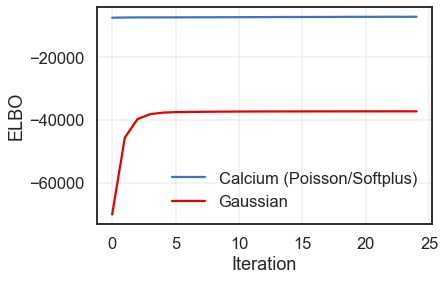

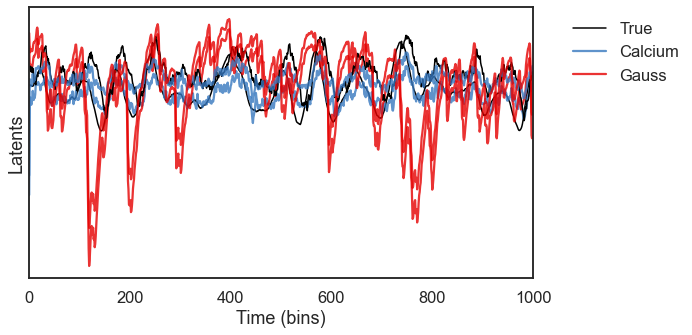

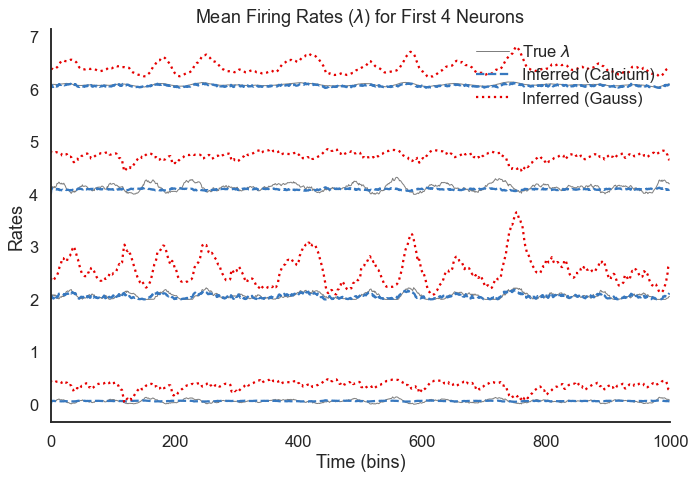

In [25]:
###ELBO

plt.figure(figsize=(6, 4))
plt.plot(q_elbos[1:], color=colors[0], label="Calcium (Poisson/Softplus)")
plt.plot(q_elbos_gauss[1:], color=colors[1], label="Gaussian")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(alpha=0.3)
plt.legend(frameon=False)


###LATENT
plt.figure(figsize=(10, 5))
x_offset = 4
time_axis = onp.arange(x.shape[0])

for d in range(D):
    # Plot true, calcium-inferred, and gauss-inferred states
    plt.plot(time_axis, x[:, d] + x_offset * d, '-k', lw=1.5, label="True" if d == 0 else None)
    plt.plot(time_axis, q_x_trans[:, d] + x_offset * d, color=colors[0], alpha=0.8, label="Calcium" if d == 0 else None)
    plt.plot(time_axis, q_x_trans_gauss[:, d] + x_offset * d, color=colors[1], alpha=0.8, label="Gauss" if d == 0 else None)

plt.xlabel("Time (bins)")
plt.ylabel("Latents")
plt.xlim(0, 1000)
plt.yticks([]) # Offsets make specific y-values arbitrary
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
smooth_y = lds.smooth(q_x, y)
smooth_y_gauss = lds_gauss.smooth(q_x_gauss, y)

plt.figure(figsize=(10, 7))
n_show = 4  # Number of neurons to display
y_offset = 2.0 

for n in range(n_show):
    # True lambda vs Inferred
    plt.plot(lambdas[:, n] + y_offset * n, '-k', lw=1, alpha=0.5, label="True $\lambda$" if n == 0 else None)
    plt.plot(inf_lambdas[:, n] + y_offset * n, '--', color=colors[0], label="Inferred (Calcium)" if n == 0 else None)
    plt.plot(smooth_y_gauss[:, n] + y_offset * n, ':', color=colors[1], label="Inferred (Gauss)" if n == 0 else None)

plt.xlabel("Time (bins)")
plt.ylabel("Rates")
plt.title(f"Mean Firing Rates ($\lambda$) for First {n_show} Neurons")
plt.xlim(0, T)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
